In [4]:
# ✅ Cleaned, Generalized, GPU-Supported LeafNet-H++ Notebook Code

import tensorflow as tf
from keras import layers, models, callbacks, optimizers
from keras.layers import (Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, 
                          BatchNormalization, Concatenate, Multiply, Activation, Reshape, GlobalMaxPooling2D)
from keras.applications import EfficientNetV2B0
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*tight_layout.*")
warnings.filterwarnings("ignore", message=".*Glyph.*missing from current font.*")

In [5]:
# GPU check
gpu_devices = tf.config.list_physical_devices('GPU')
if gpu_devices:
    print(f"✅ GPU is available: {gpu_devices[0]}")
else:
    print("❌ GPU not available")

✅ GPU is available: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [6]:
# --- Dataset Paths ---
dataset_dir = "/kaggle/input/plant-leaf-diseases/Plant_leaf_diseases_dataset_without_augmentation/Plant_leave_diseases_dataset_without_augmentation"

print(dataset_dir)

/kaggle/input/plant-leaf-diseases/Plant_leaf_diseases_dataset_without_augmentation/Plant_leave_diseases_dataset_without_augmentation


In [7]:
# --- Dataset Loading ---
batch_size = 32
img_size = (224, 224)

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Classes: {class_names}")

train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


Found 55448 files belonging to 39 classes.
Using 44359 files for training.


I0000 00:00:1753588904.067157      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 55448 files belonging to 39 classes.
Using 11089 files for validation.
Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mit

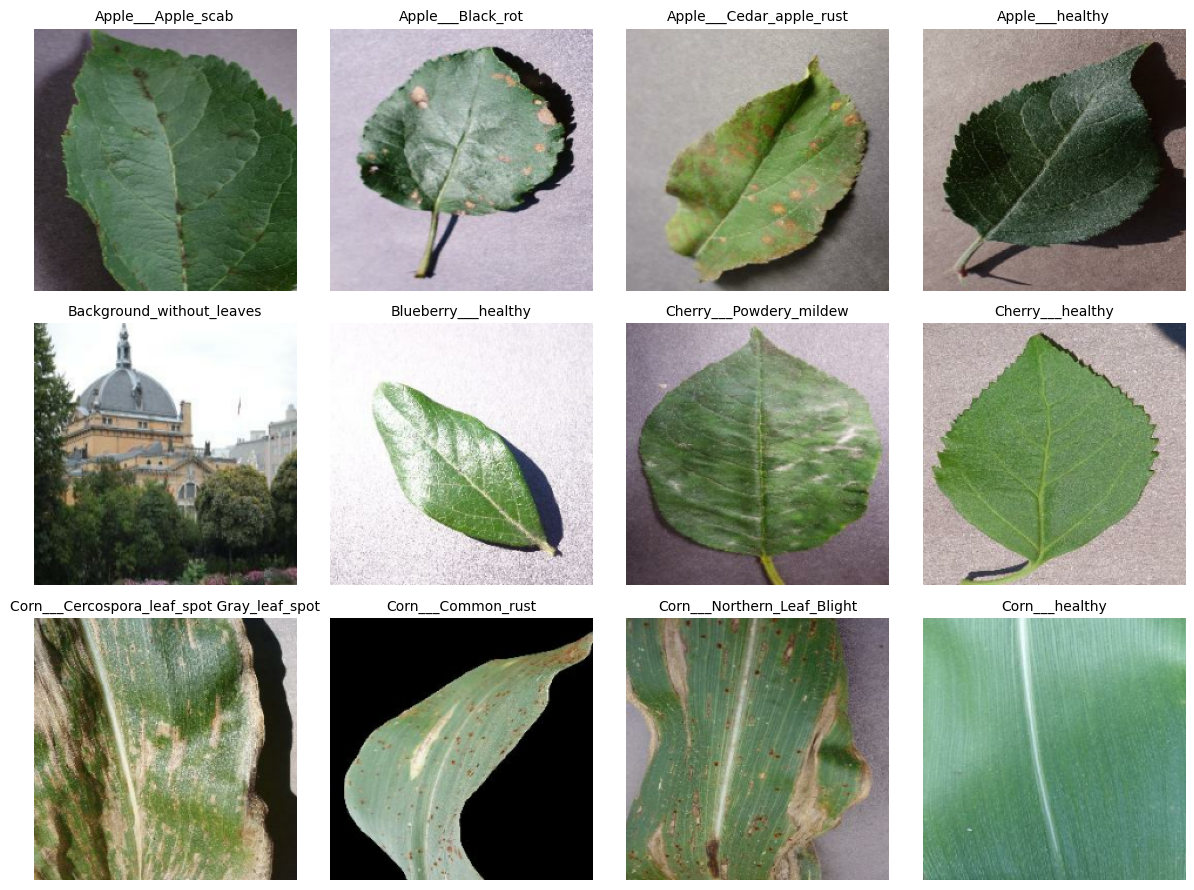

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Get one image per class
images_per_class = {}
found_classes = set()

# Fetch images from dataset
for images, labels in train_ds:
    for img, label in zip(images, labels):
        class_idx = label.numpy()
        class_name = class_names[class_idx]

        if class_name not in found_classes:
            images_per_class[class_name] = img
            found_classes.add(class_name)

        if len(found_classes) == len(class_names):
            break
    if len(found_classes) == len(class_names):
        break

# Set up grid
cols = 4
rows = 3
max_plots = rows * cols

plt.figure(figsize=(cols * 3, rows * 3))

# Loop through limited number of classes
for idx, class_name in enumerate(class_names[:max_plots]):
    plt.subplot(rows, cols, idx + 1)
    plt.imshow(images_per_class[class_name].numpy().astype("uint8"))
    plt.title(class_name, fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [9]:
# --- SE Block ---
def se_block(input_tensor, reduction=16):
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(filters // reduction, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Reshape((1, 1, filters))(se)
    return Multiply()([input_tensor, se])

# --- Attention Module ---
def attention_module(inputs):
    avg_pool = GlobalAveragePooling2D()(inputs)
    max_pool = GlobalMaxPooling2D()(inputs)
    concat = Concatenate()([avg_pool, max_pool])
    dense = Dense(inputs.shape[-1] // 8, activation='relu')(concat)
    dense = Dense(inputs.shape[-1], activation='sigmoid')(dense)
    scale = Multiply()([inputs, Reshape((1, 1, inputs.shape[-1]))(dense)])
    return scale

# --- LeafNet-H++ Architecture ---
def LeafNet_Hpp(input_shape=(224, 224, 3), num_classes=num_classes):
    base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = True  # ✅ Fine-tuning enabled

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=True)
    x = attention_module(x)
    x = se_block(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

model = LeafNet_Hpp()
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [10]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetv2-b0   │ (None, 7, 7,      │  5,919,312 │ input_layer_1[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetv2-b… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 1280)      │          0 │ efficientnetv2-b… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2560)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 160)       │    409,760 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1280)      │    206,080 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1,      │          0 │ dense_1[0][0]     │
│                     │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 7, 7,      │          0 │ efficientnetv2-b… │
│                     │ 1280)             │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ multiply[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 80)        │    102,480 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1280)      │    103,680 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1,      │          0 │ dense_3[0][0]     │
│                     │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 7, 7,      │          0 │ multiply[0][0],   │
│ (Multiply)          │ 1280)             │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ multiply_1[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1280)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 39)        │     49,959 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,791,271 (25.91 MB)

 Trainable params: 6,730,663 (25.68 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [19]:
# --- Callbacks ---
checkpoint = callbacks.ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True)
early_stop = EarlyStoppingByAccuracy()
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
cosine_lr = callbacks.LearningRateScheduler(cosine_schedule)



In [21]:

# --- Training ---
history = model.fit(
    train_ds,
    validation_data=val_ds,
    steps_per_epoch=500,             # ✅ Fixed spelling and added as requested
    epochs=30,
    callbacks=[early_stop, reduce_lr, cosine_lr]
)


Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 51s 102ms/step - accuracy: 0.9986 - loss: 0.0057 - val_accuracy: 0.9973 - val_loss: 0.0108 - learning_rate: 1.0000e-04
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 51s 102ms/step - accuracy: 0.9983 - loss: 0.0055 - val_accuracy: 0.9969 - val_loss: 0.0109 - learning_rate: 9.9863e-05
Epoch 3/30
386/500 ━━━━━━━━━━━━━━━━━━━━ 9s 86ms/step - accuracy: 0.9983 - loss: 0.0068

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 83ms/step - accuracy: 0.9983 - loss: 0.0066 - val_accuracy: 0.9971 - val_loss: 0.0093 - learning_rate: 9.9452e-05
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 51s 101ms/step - accuracy: 0.9977 - loss: 0.0085 - val_accuracy: 0.9969 - val_loss: 0.0108 - learning_rate: 9.8769e-05
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 51s 102ms/step - accuracy: 0.9983 - loss: 0.0053 - val_accuracy: 0.9977 - val_loss: 0.0102 - learning_rate: 9.7815e-05
Epoch 6/30
386/500 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.9994 - loss: 0.0026
Epoch 6: ReduceLROnPlateau reducing learning rate to 1.931851584231481e-05.
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 82ms/step - accuracy: 0.9994 - loss: 0.0026 - val_accuracy: 0.9977 - val_loss: 0.0095 - learning_rate: 1.9319e-05
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 51s 102ms/step - accuracy: 0.9984 - loss: 0.0047 - val_accuracy: 0.9968 - val_loss: 0.0107 - learning_rate: 9.5106e-05
Epoch 8/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 51s 102ms/step - accuracy:

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_36/948548718.py:43: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


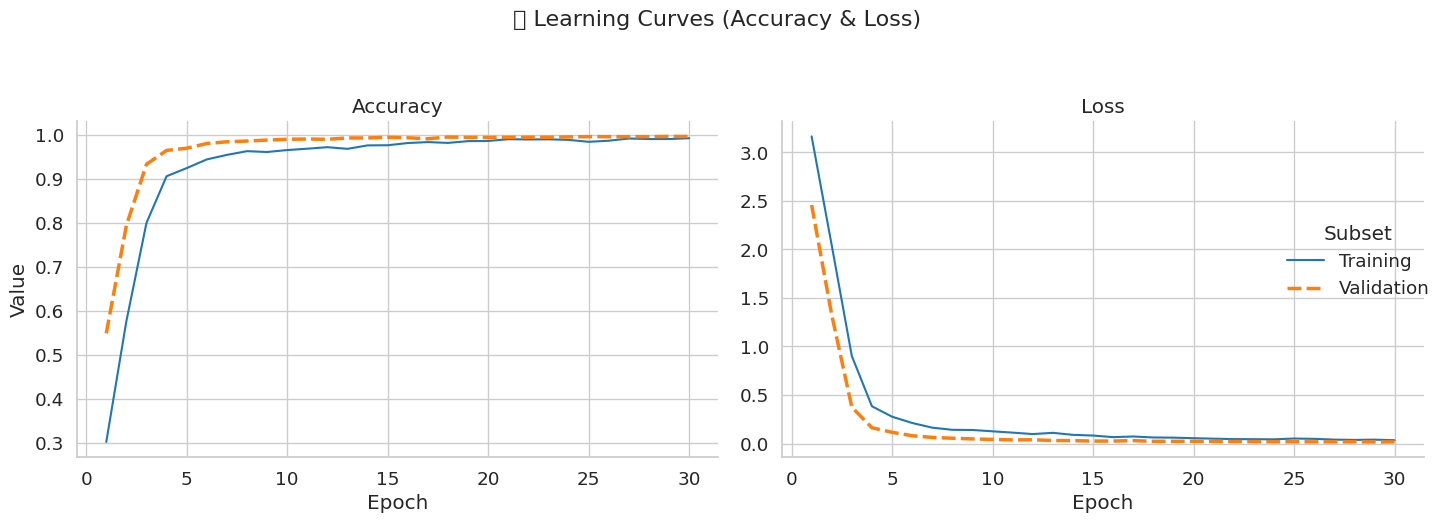

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*tight_layout.*")
warnings.filterwarnings("ignore", message=".*Glyph.*missing from current font.*")


# Convert Keras history to long-form DataFrame
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history_df.index + 1

df = history_df.melt(
    id_vars='epoch',
    value_vars=['accuracy', 'val_accuracy', 'loss', 'val_loss'],
    var_name='metric',
    value_name='value'
)

# Add columns for plotting
df['type'] = df['metric'].apply(lambda x: 'Accuracy' if 'accuracy' in x else 'Loss')
df['subset'] = df['metric'].apply(lambda x: 'Validation' if 'val' in x else 'Training')

sns.set(style="whitegrid", font_scale=1.2)
palette = {"Training": "#1f77b4", "Validation": "#ff7f0e"}
line_sizes = {"Training": 1.5, "Validation": 2.5}

# Create the FacetGrid
g = sns.FacetGrid(df, col="type", height=5, aspect=1.3, sharey=False)
g.map_dataframe(
    sns.lineplot,
    x="epoch", y="value",
    hue="subset", style="subset", size="subset",
    palette=palette, sizes=line_sizes
)

# Improve legend, labels, and titles
g.add_legend(title="Subset")
g.set_axis_labels("Epoch", "Value")
g.set_titles("{col_name}")
g.fig.suptitle("📈 Learning Curves (Accuracy & Loss)", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

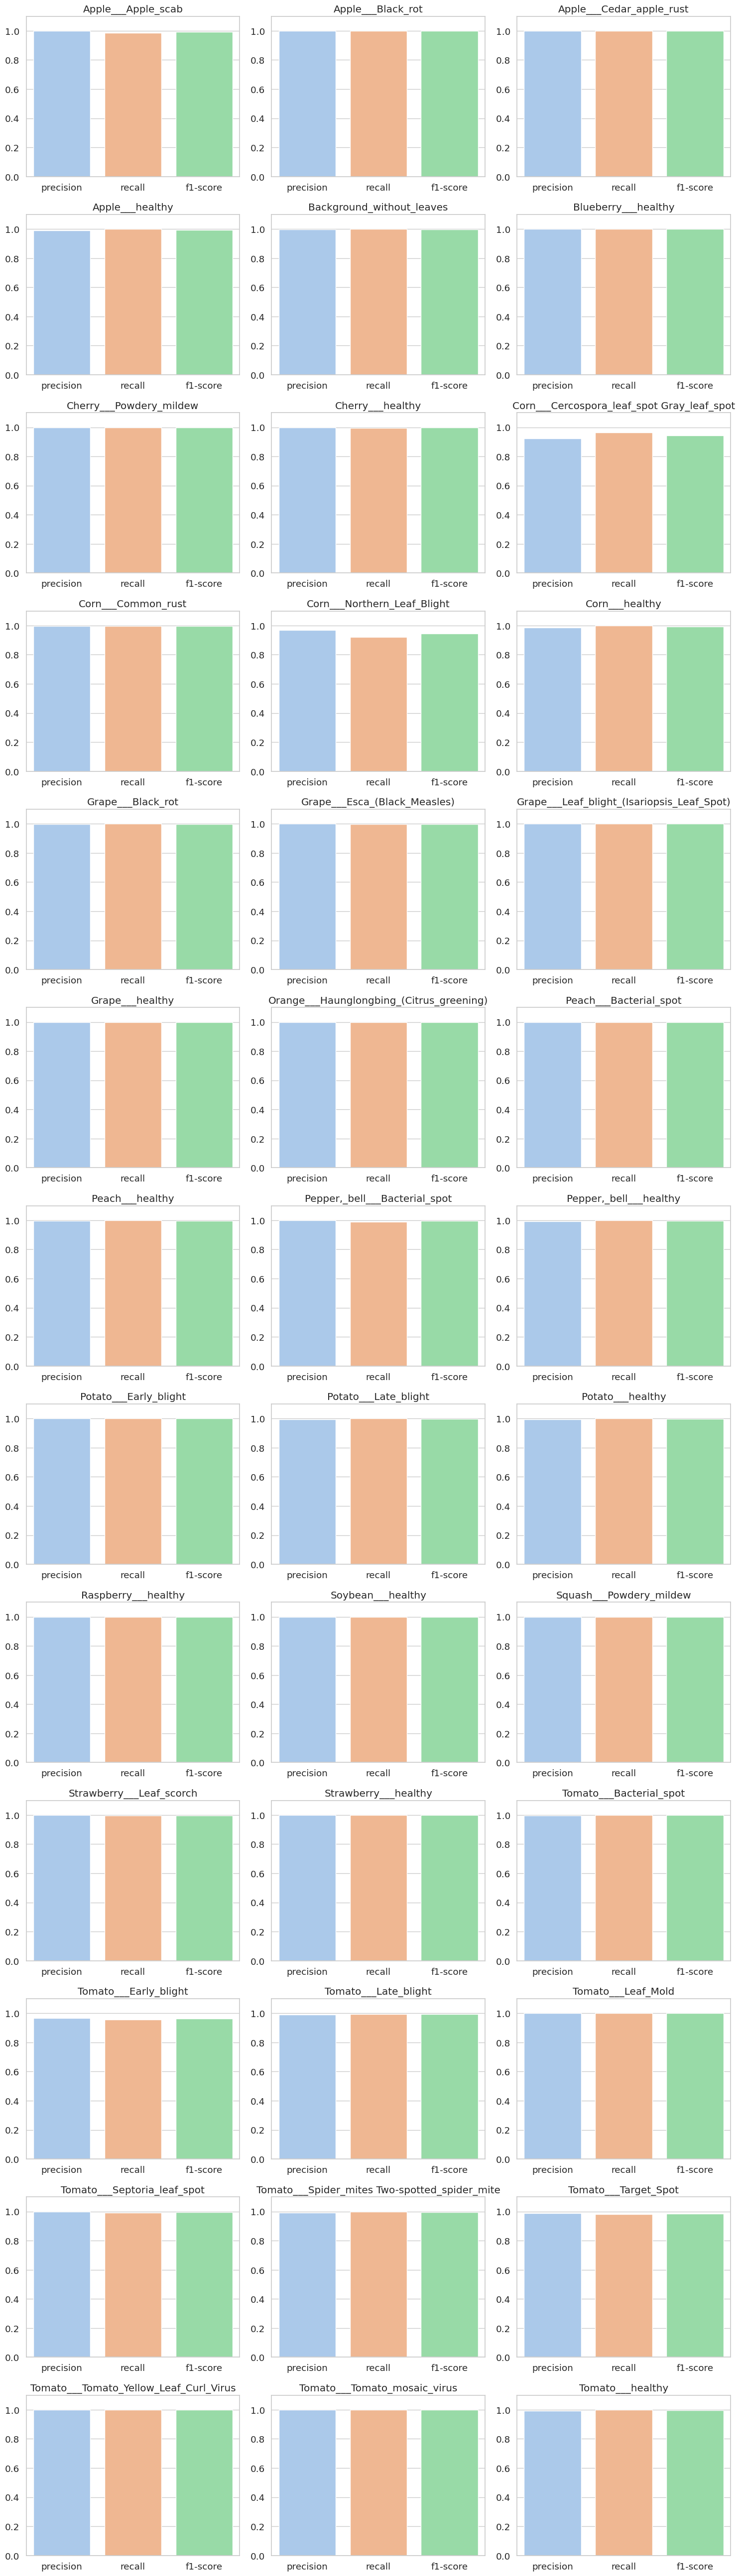

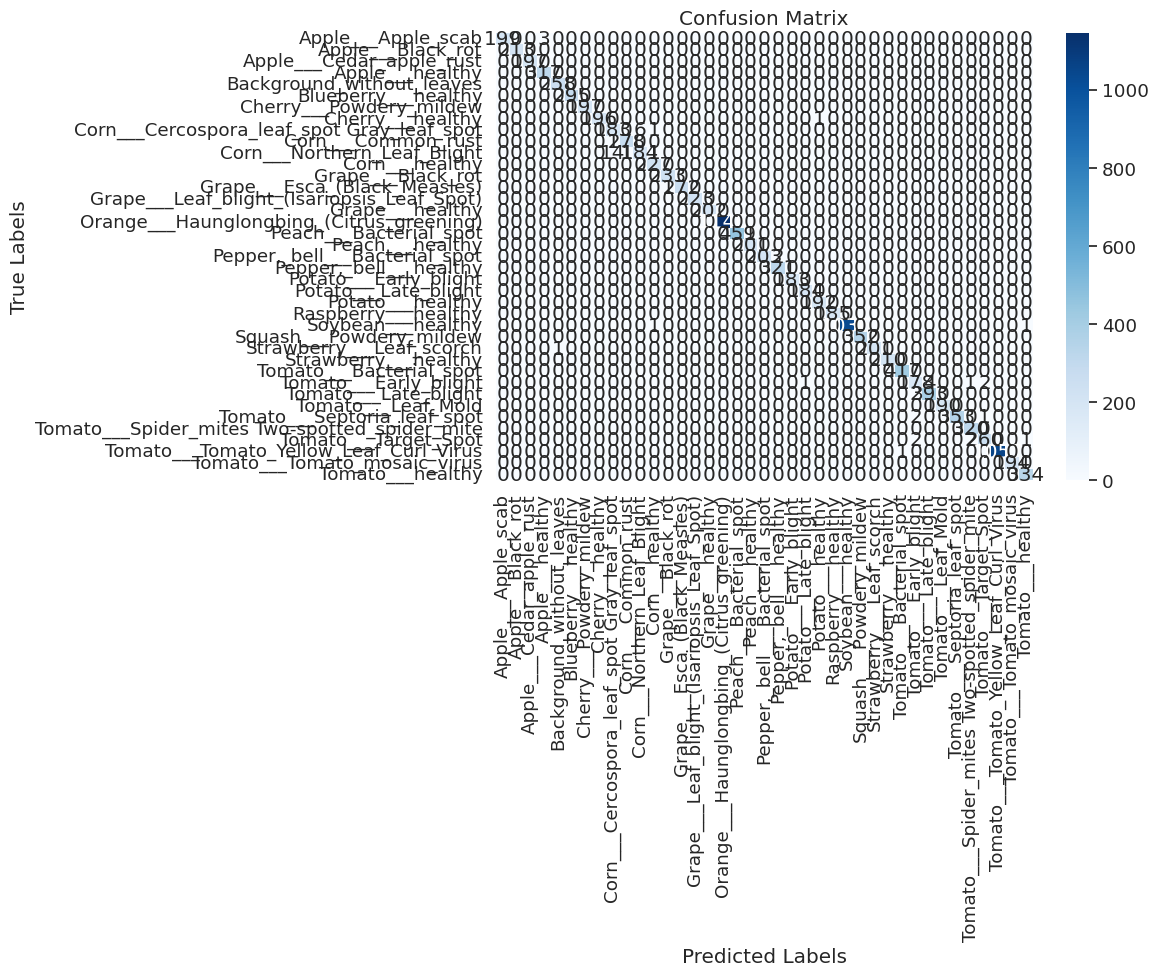

In [38]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*tight_layout.*")
warnings.filterwarnings("ignore", message=".*Glyph.*missing from current font.*")

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.metrics import classification_report, confusion_matrix

# --- Reconstruct true labels ---
y_true = []
y_pred_probs = []

for images, labels in val_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=-1) if len(labels.shape) > 1 else labels.numpy())
    preds = model.predict(images, verbose=0)
    y_pred_probs.extend(preds)

y_true = np.array(y_true)
y_pred = np.argmax(y_pred_probs, axis=1)

# --- Classification Report ---
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# --- Per-class metric plots ---
metrics = ['precision', 'recall', 'f1-score']
colors = sns.color_palette("pastel")
num_classes = len(class_names)
cols = 3
rows = math.ceil(num_classes / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

for idx, cls in enumerate(class_names):
    vals = [report[cls][m] for m in metrics]
    sns.barplot(x=metrics, y=vals, ax=axes[idx], palette=colors)
    axes[idx].set_title(cls)
    axes[idx].set_ylim(0, 1.1)

# Remove extra axes
for i in range(num_classes, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Prepare DataFrame from predictions ---
prob_df = pd.DataFrame(y_pred_probs, columns=pretty_class_names)
prob_df['Actual Class'] = [pretty_class_names[i] for i in y_true]

# ✅ Use only 3 classes
selected_classes = pretty_class_names[:3]
subset_df = prob_df[selected_classes + ['Actual Class']]

# ✅ Sample only 100 rows
subset_df = subset_df.sample(100, random_state=42)

# --- Pairplot (scatter + distribution) ---
sns.pairplot(
    subset_df,
    vars=selected_classes,
    hue='Actual Class',
    palette='tab10',
    diag_kind='kde',
    plot_kws={'s': 20, 'alpha': 0.6}
)

plt.suptitle("Pair Plot of Predicted Probabilities (Scatter + Distribution)", y=1.02, fontsize=16)
plt.gcf().set_size_inches(12, 8)
plt.show()


/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


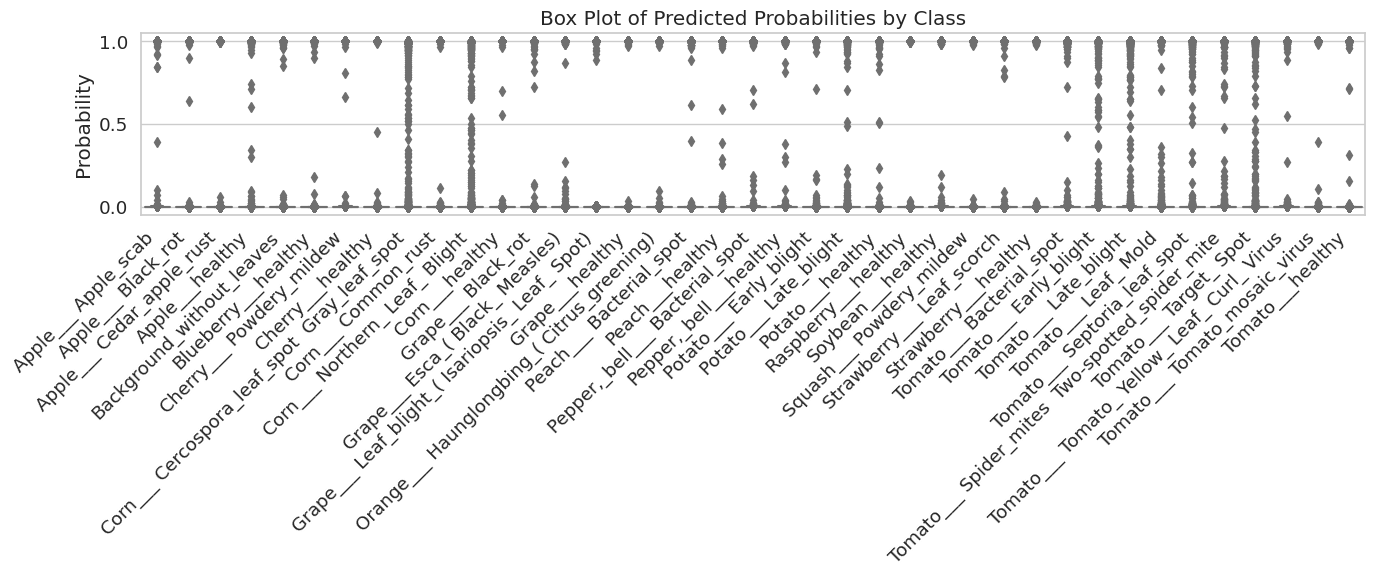

In [40]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=prob_df[pretty_class_names], palette='pastel')
plt.title("Box Plot of Predicted Probabilities by Class")
plt.ylabel("Probability")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [22]:
# --- Dataset Paths ---
dataset_dir = "/kaggle/input/plant-leaf-diseases/Plant_leaf_diseases_dataset_with_augmentation/Plant_leave_diseases_dataset_with_augmentation"

print(dataset_dir)

/kaggle/input/plant-leaf-diseases/Plant_leaf_diseases_dataset_with_augmentation/Plant_leave_diseases_dataset_with_augmentation


In [23]:
# --- Dataset Loading ---
batch_size = 32
img_size = (224, 224)

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)
print(f"Classes: {class_names}")

train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


Found 61486 files belonging to 39 classes.
Using 49189 files for training.
Found 61486 files belonging to 39 classes.
Using 12297 files for validation.
Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Background_without_leaves', 'Blueberry___healthy', 'Cherry___Powdery_mildew', 'Cherry___healthy', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___Northern_Leaf_Blight', 'Corn___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight'

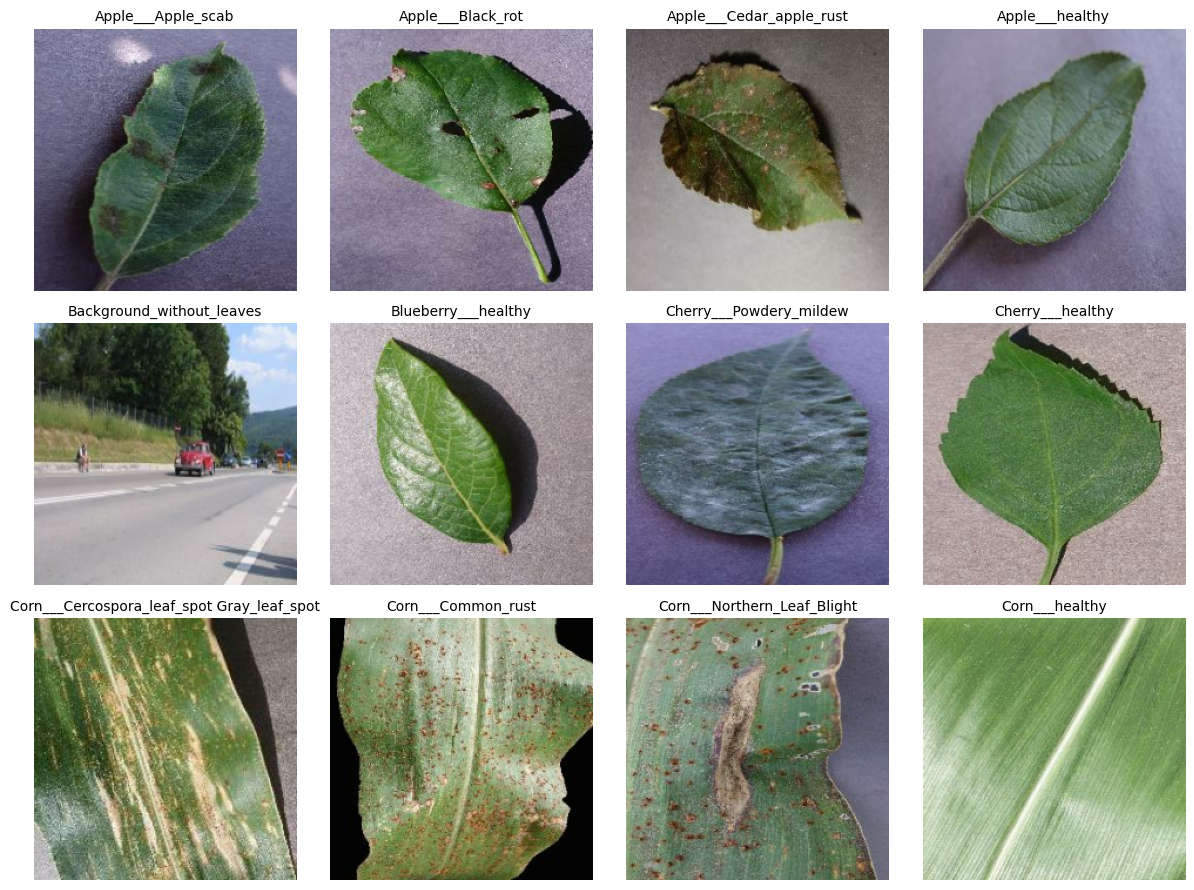

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# Get one image per class
images_per_class = {}
found_classes = set()

# Fetch images from dataset
for images, labels in train_ds:
    for img, label in zip(images, labels):
        class_idx = label.numpy()
        class_name = class_names[class_idx]

        if class_name not in found_classes:
            images_per_class[class_name] = img
            found_classes.add(class_name)

        if len(found_classes) == len(class_names):
            break
    if len(found_classes) == len(class_names):
        break

# Set up grid
cols = 4
rows = 3
max_plots = rows * cols

plt.figure(figsize=(cols * 3, rows * 3))

# Loop through limited number of classes
for idx, class_name in enumerate(class_names[:max_plots]):
    plt.subplot(rows, cols, idx + 1)
    plt.imshow(images_per_class[class_name].numpy().astype("uint8"))
    plt.title(class_name, fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()

In [25]:
# --- SE Block ---
def se_block(input_tensor, reduction=16):
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(filters // reduction, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Reshape((1, 1, filters))(se)
    return Multiply()([input_tensor, se])

# --- Attention Module ---
def attention_module(inputs):
    avg_pool = GlobalAveragePooling2D()(inputs)
    max_pool = GlobalMaxPooling2D()(inputs)
    concat = Concatenate()([avg_pool, max_pool])
    dense = Dense(inputs.shape[-1] // 8, activation='relu')(concat)
    dense = Dense(inputs.shape[-1], activation='sigmoid')(dense)
    scale = Multiply()([inputs, Reshape((1, 1, inputs.shape[-1]))(dense)])
    return scale

# --- LeafNet-H++ Architecture ---
def LeafNet_Hpp(input_shape=(224, 224, 3), num_classes=num_classes):
    base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = True  # ✅ Fine-tuning enabled

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=True)
    x = attention_module(x)
    x = se_block(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)

model = LeafNet_Hpp()
model.compile(optimizer=optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [26]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetv2-b0   │ (None, 7, 7,      │  5,919,312 │ input_layer_3[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetv2-b… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 1280)      │          0 │ efficientnetv2-b… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 2560)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 160)       │    409,760 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1280)      │    206,080 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 1, 1,      │          0 │ dense_6[0][0]     │
│                     │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 7, 7,      │          0 │ efficientnetv2-b… │
│ (Multiply)          │ 1280)             │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ multiply_2[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 80)        │    102,480 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1280)      │    103,680 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1, 1,      │          0 │ dense_8[0][0]     │
│                     │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 7, 7,      │          0 │ multiply_2[0][0], │
│ (Multiply)          │ 1280)             │            │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ multiply_3[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 1280)      │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 39)        │     49,959 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,791,271 (25.91 MB)

 Trainable params: 6,730,663 (25.68 MB)

 Non-trainable params: 60,608 (236.75 KB)

In [27]:
# --- Callbacks ---
checkpoint = callbacks.ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True)
early_stop = EarlyStoppingByAccuracy()
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
cosine_lr = callbacks.LearningRateScheduler(cosine_schedule)

In [28]:


# --- Training ---
history = model.fit(
    train_ds,
    validation_data=val_ds,
    steps_per_epoch=100,             # ✅ Fixed spelling and added as requested
    epochs=30,
    callbacks=[early_stop, reduce_lr, cosine_lr]
)

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 131s 368ms/step - accuracy: 0.1810 - loss: 3.4605 - val_accuracy: 0.5488 - val_loss: 2.4569 - learning_rate: 1.0000e-04
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 174ms/step - accuracy: 0.5100 - loss: 2.3072 - val_accuracy: 0.7937 - val_loss: 1.3247 - learning_rate: 9.9863e-05
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 174ms/step - accuracy: 0.7384 - loss: 1.1751 - val_accuracy: 0.9325 - val_loss: 0.3745 - learning_rate: 9.9452e-05
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 172ms/step - accuracy: 0.8973 - loss: 0.4380 - val_accuracy: 0.9639 - val_loss: 0.1627 - learning_rate: 9.8769e-05
Epoch 5/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 173ms/step - accuracy: 0.9237 - loss: 0.2783 - val_accuracy: 0.9689 - val_loss: 0.1159 - learning_rate: 9.7815e-05
Epoch 6/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 173ms/step - accuracy: 0.9432 - loss: 0.2197 - val_accuracy: 0.9796 - val_loss: 0.0806 - learning_rate: 9.6593e-05
Epoch 7/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 17s 1

/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/tmp/ipykernel_36/948548718.py:43: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


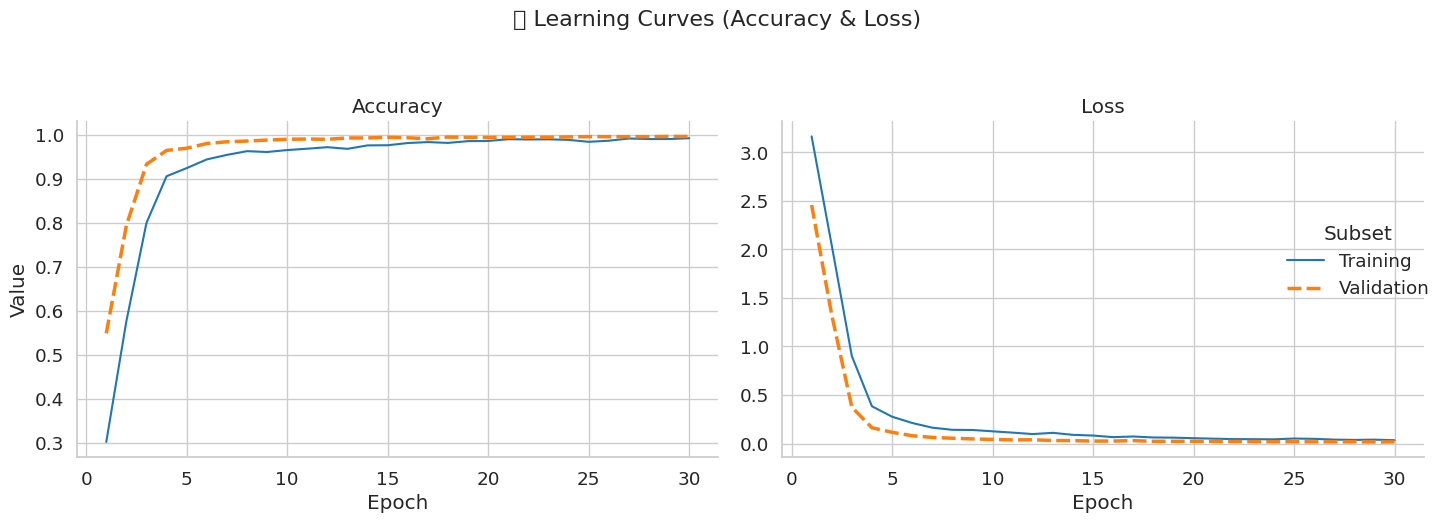

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*tight_layout.*")
warnings.filterwarnings("ignore", message=".*Glyph.*missing from current font.*")


# Convert Keras history to long-form DataFrame
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history_df.index + 1

df = history_df.melt(
    id_vars='epoch',
    value_vars=['accuracy', 'val_accuracy', 'loss', 'val_loss'],
    var_name='metric',
    value_name='value'
)

# Add columns for plotting
df['type'] = df['metric'].apply(lambda x: 'Accuracy' if 'accuracy' in x else 'Loss')
df['subset'] = df['metric'].apply(lambda x: 'Validation' if 'val' in x else 'Training')

sns.set(style="whitegrid", font_scale=1.2)
palette = {"Training": "#1f77b4", "Validation": "#ff7f0e"}
line_sizes = {"Training": 1.5, "Validation": 2.5}

# Create the FacetGrid
g = sns.FacetGrid(df, col="type", height=5, aspect=1.3, sharey=False)
g.map_dataframe(
    sns.lineplot,
    x="epoch", y="value",
    hue="subset", style="subset", size="subset",
    palette=palette, sizes=line_sizes
)

# Improve legend, labels, and titles
g.add_legend(title="Subset")
g.set_axis_labels("Epoch", "Value")
g.set_titles("{col_name}")
g.fig.suptitle("📈 Learning Curves (Accuracy & Loss)", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

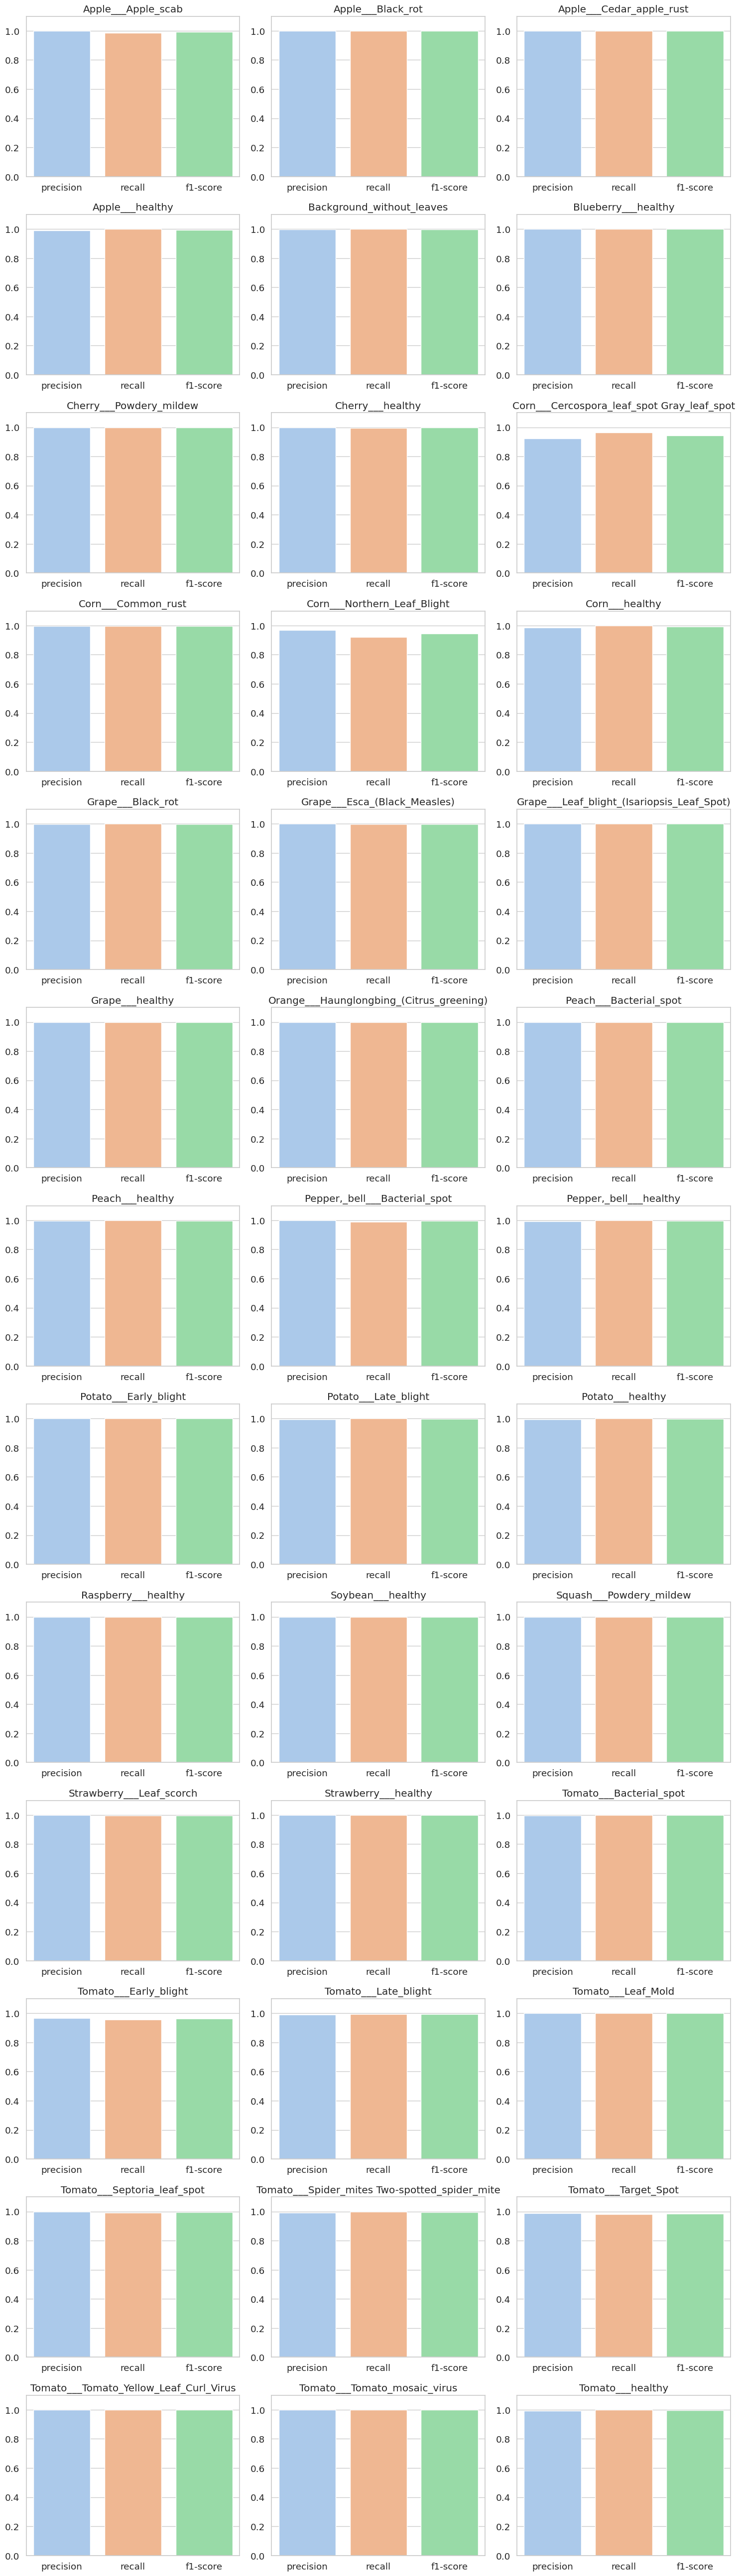

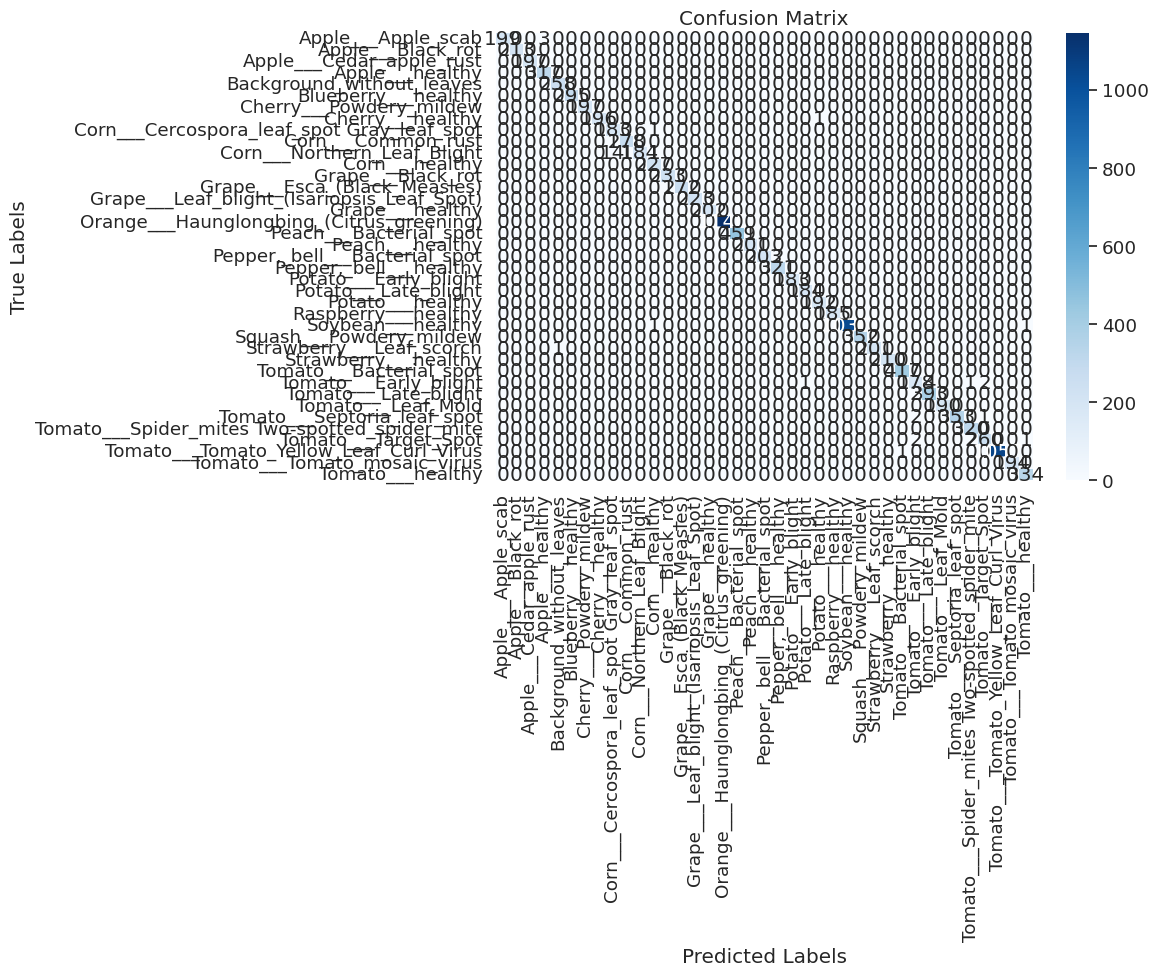

In [34]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message=".*tight_layout.*")
warnings.filterwarnings("ignore", message=".*Glyph.*missing from current font.*")

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.metrics import classification_report, confusion_matrix

# --- Reconstruct true labels ---
y_true = []
y_pred_probs = []

for images, labels in val_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=-1) if len(labels.shape) > 1 else labels.numpy())
    preds = model.predict(images, verbose=0)
    y_pred_probs.extend(preds)

y_true = np.array(y_true)
y_pred = np.argmax(y_pred_probs, axis=1)

# --- Classification Report ---
report = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)

# --- Per-class metric plots ---
metrics = ['precision', 'recall', 'f1-score']
colors = sns.color_palette("pastel")
num_classes = len(class_names)
cols = 3
rows = math.ceil(num_classes / cols)

fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

for idx, cls in enumerate(class_names):
    vals = [report[cls][m] for m in metrics]
    sns.barplot(x=metrics, y=vals, ax=axes[idx], palette=colors)
    axes[idx].set_title(cls)
    axes[idx].set_ylim(0, 1.1)

# Remove extra axes
for i in range(num_classes, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
plt.show()
